# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import pandas as pd

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"

sns.set_style('whitegrid')

In [2]:
torch.cuda.is_available()

True

# Load and pre process data

In [3]:
data = pd.read_csv('ticks.csv')
data.head()

,Date,Hyperlink,Blog,PostNb,WeightOfLink
0,2009-01-01 00:04:10,http://ameblo.jp,http://ameblo.jp,149,0.5
1,2009-01-01 00:04:15,http://reddit.com,http://reddit.com,158,1.0
2,2009-01-01 00:04:33,http://pr-inside.com,http://pr-inside.com,213,1.0
3,2009-01-01 00:04:33,http://pr-inside.com,http://pr-inside.com,214,1.0
4,2009-01-01 00:05:00,http://de.answers.yahoo.com,http://de.answers.yahoo.com,268,1.0


In [4]:
data['Date'] = data["Date"].apply(pd.to_datetime)
data['Time'] = data['Date'].apply(pd.Timestamp)
data['Time'] = data['Time'].apply(lambda x: x.timestamp())
t_begin = data['Time'].min()
data['Time'] = data['Time'].apply(lambda x : x - t_begin) # Normalization
grouped = data.groupby(['Hyperlink'])['Time'].apply(np.array).reset_index(name='Times')
grouped['Length'] = grouped['Times'].apply(len)
grouped['Times'] = grouped['Times'].apply(np.sort)

In [5]:
grouped.head()

,Hyperlink,Times,Length
0,http://1.bp.blogspot.com,"[180906.0, 182723.0, 182969.0, 184891.0, 18535...",50
1,http://2.bp.blogspot.com,"[182871.0, 182969.0, 184223.0, 186002.0, 75989...",48
2,http://3.bp.blogspot.com,"[172889.0, 182969.0, 184356.0, 185688.0, 23699...",56
3,http://4.bp.blogspot.com,"[47463.0, 170628.0, 182969.0, 184674.0, 185625...",56
4,http://4travel.jp,"[1026.0, 1027.0, 1027.0, 1027.0, 1027.0, 2797....",8874


(array([3.27666635e-07, 4.08816503e-07, 4.26684364e-07, 3.95756834e-07,
        4.12399381e-07, 3.72266491e-07, 3.69854640e-07, 3.13257570e-07,
        3.66554824e-07, 3.40726304e-07]),
 array([      0. ,  267810.5,  535621. ,  803431.5, 1071242. , 1339052.5,
        1606863. , 1874673.5, 2142484. , 2410294.5, 2678105. ]),
 <BarContainer object of 10 artists>)

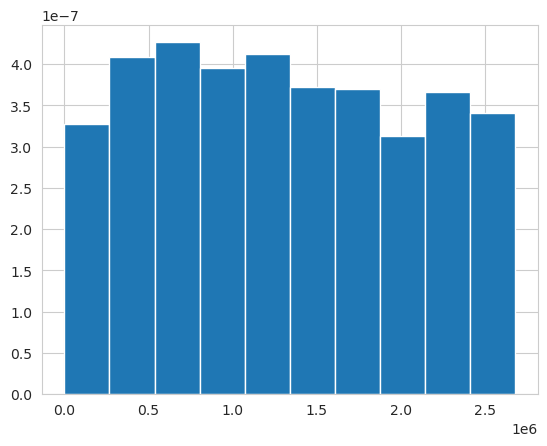

In [6]:
plt.hist(data['Time'], density=True)

(array([8.20300100e-05, 3.62458184e-05, 1.14460479e-05, 1.14460479e-05,
        1.14460479e-05, 3.81534930e-06, 0.00000000e+00, 0.00000000e+00,
        7.63069861e-06, 3.81534930e-06]),
 array([1.00000e+00, 5.95780e+03, 1.19146e+04, 1.78714e+04, 2.38282e+04,
        2.97850e+04, 3.57418e+04, 4.16986e+04, 4.76554e+04, 5.36122e+04,
        5.95690e+04]),
 <BarContainer object of 10 artists>)

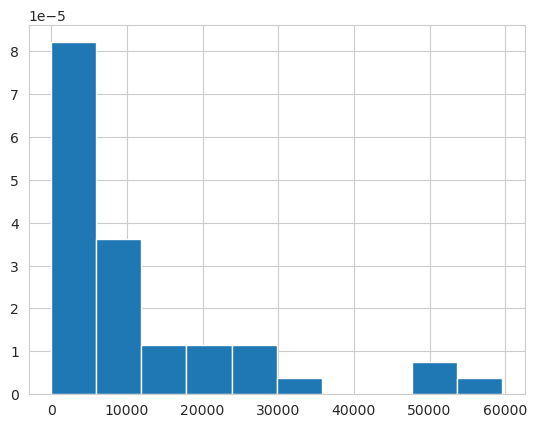

In [7]:
plt.hist(grouped['Length'], density=True)

In [8]:
t_end = grouped['Times'].apply(np.max).max()
t_end

2678105.0

In [9]:
def get_inter_times(t, t_end):
    tau = np.diff(t, prepend=0.0, append=t_end)
    return torch.tensor(tau, dtype=torch.float32, device=device)

inter_times_list = [get_inter_times(t, t_end) for t in grouped['Times'].values]
inter_times = pad_sequence(inter_times_list, batch_first=True)
seq_lengths = torch.tensor(grouped['Length'])

# Choose a parametric distribution

In [10]:
class Weibull:
    """Weibull distribution.

    Args:
        b: scale parameter b (strictly positive)
        k: shape parameter k (strictly positive)
        eps: Minimum value of x, used for numerical stability.
    """
    def __init__(self, b, k, eps=1e-8):
        self.b = b
        self.k = k
        self.eps = eps

    def log_prob(self, x):
        """Logarithm of the probability density function log(f(x))."""
        # x must have the same shape as self.b and self.k
        x = x.clamp_min(self.eps)  # pow is unstable for inputs close to 0
        return (self.b.log() + self.k.log() + (self.k - 1) * x.log()
                + self.b.neg() * torch.pow(x, self.k))

    def log_survival(self, x):
        """Logarithm of the survival function log(S(x))."""
        x = x.clamp_min(self.eps)
        return self.b.neg() * torch.pow(x, self.k)

    def sample(self, sample_shape=torch.Size()):
        """Generate a sample from the distribution."""
        # We do sampling using the inverse transform method
        # If z ~ Expo(1), then solving exp(-z) = S(x) for x produces
        # a sample from the distribution with survival function S
        shape = torch.Size(sample_shape) + self.b.shape
        z = torch.empty(shape).exponential_(1.0)
        return (z * self.b.reciprocal() + self.eps).pow(self.k.reciprocal())

# Define the model

In [11]:
class NeuralTPP(nn.Module):
    """A simple neural TPP model with an RNN encoder.

    Args:
        context_size: Size of the RNN hidden state.
    """
    def __init__(self, context_size=32):
        super().__init__()
        self.context_size = context_size
        # Used to embed the event history into a context vector
        self.rnn = nn.GRU(
            input_size=2,
            hidden_size=context_size,
            batch_first=True,
        )
        # Used to obtain model parameters from the context vector
        self.hypernet = nn.Linear(
            in_features=context_size,
            out_features=2,
        )

    def get_context(self, inter_times):
        """Get context embedding for each event in each sequence.

        Args:
            inter_times: Padded inter-event times, shape (B, L)

        Returns:
            context: Context vectors, shape (B, L, C)
        """
        tau = inter_times.unsqueeze(-1)
        # Clamp tau to avoid computing log(0) for padding and getting NaNs
        log_tau = inter_times.clamp_min(1e-8).log().unsqueeze(-1)  # (B, L, 1)
        rnn_input = torch.cat([tau, log_tau], dim=-1)
        # The intial state is automatically set to zeros
        rnn_output = self.rnn(rnn_input)[0]  # (B, L, C)
        # Shift by one such that context[:, i] will be used
        # to parametrize the distribution of inter_times[:, i]
        context = F.pad(rnn_output[:, :-1, :], (0, 0, 1, 0))  # (B, L, C)
        return context

    def get_inter_time_distribution(self, context):
        """Get context embedding for each event in each sequence.

        Args:
            context: Context vectors, shape (B, L, C)

        Returns:
            dist: Conditional distribution over the inter-event times
        """
        raw_params = self.hypernet(context)  # (B, L, 2)
        b = F.softplus(raw_params[..., 0])  # (B, L)
        k = F.softplus(raw_params[..., 1])  # (B, L)
        return Weibull(b=b, k=k)

    def nll_loss(self, inter_times, seq_lengths):
        """Compute negative log-likelihood for a batch of sequences.

        Args:
            inter_times: Padded inter_event times, shape (B, L)
            seq_lengths: Number of events in each sequence, shape (B,)

        Returns:
            log_p: Log-likelihood for each sequence, shape (B,)
        """
        context = self.get_context(inter_times)  # (B, L, C)
        inter_time_dist = self.get_inter_time_distribution(context)

        log_pdf = inter_time_dist.log_prob(inter_times)  # (B, L)
        # Construct a boolean mask that selects observed events
        arange = torch.arange(inter_times.shape[1], device=seq_lengths.device)
        mask = (arange[None, :] < seq_lengths[:, None]).float()  # (B, L)
        log_like = (log_pdf * mask).sum(-1)  # (B,)

        log_surv = inter_time_dist.log_survival(inter_times)  # (B, L)
        end_idx = seq_lengths.unsqueeze(-1)  # (B, 1)
        log_surv_last = torch.gather(log_surv, dim=-1, index=end_idx)  # (B, 1)
        log_like += log_surv_last.squeeze(-1)  # (B,)
        return -log_like

    def sample(self, batch_size, t_end):
        """Generate an event sequence from the TPP.

        Args:
            batch_size: Number of samples to generate in parallel.
            t_end: Time until which the TPP is simulated.

        Returns:
            inter_times: Padded inter-event times, shape (B, L)
            seq_lengths: Number of events in each sequence, shape (B,)
        """
        inter_times = torch.empty([batch_size, 0])
        next_context = torch.zeros(batch_size, 1, self.context_size)
        generated = False
        while not generated:
            inter_time_dist = self.get_inter_time_distribution(next_context)
            next_inter_times = inter_time_dist.sample()  # (B, 1)
            inter_times = torch.cat([inter_times, next_inter_times], dim=1)  # (B, L)

            # Obtain the next context vector
            tau = next_inter_times.unsqueeze(-1)  # (B, 1, 1)
            log_tau = next_inter_times.clamp_min(1e-8).log().unsqueeze(-1)  # (B, 1, 1)
            rnn_input = torch.cat([tau, log_tau], dim=-1)  # (B, 1, 2)
            next_context = self.rnn(rnn_input, next_context.transpose(0, 1))[0]  # (B, 1, C)

            # Check if the end of the interval has been reached
            generated = inter_times.sum(-1).min() >= t_end
        # Convert the sample to the same format as our input data
        arrival_times = inter_times.cumsum(-1)
        seq_lengths = (arrival_times < t_end).sum(-1).long()
        inter_times = arrival_times - F.pad(arrival_times, (1, 0))[..., :-1]
        return inter_times, seq_lengths

# Train the model

In [12]:
inter_times.device

device(type='cuda', index=0)

In [13]:
model = NeuralTPP()
opt = torch.optim.Adam(model.parameters(), lr=5e-3)

max_epochs = 300
for epoch in range(max_epochs + 1):
    opt.zero_grad()
    loss = model.nll_loss(inter_times, seq_lengths).mean() / t_end
    loss.backward()
    opt.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.3f}")

Epoch 0: loss = 0.045
Epoch 50: loss = -0.032
Epoch 100: loss = -0.032
Epoch 150: loss = -0.032
Epoch 200: loss = -0.032
Epoch 250: loss = -0.033
Epoch 300: loss = -0.033


# Sample event sequences from the model

In [14]:
arrival_times_list = grouped['Times'].values

In [15]:
with torch.no_grad():
    gen_inter_times, gen_seq_lengths = model.sample(1000, t_end)
gen_arrival_times = gen_inter_times.cumsum(-1)
generated_sequences = []
for i in range(gen_arrival_times.shape[0]):
    t = gen_arrival_times[i, :gen_seq_lengths[i]].cpu().numpy()
    generated_sequences.append(t)

In [16]:
seq_lengths = seq_lengths.cpu().numpy()
gen_seq_lengths = gen_seq_lengths.cpu().numpy()

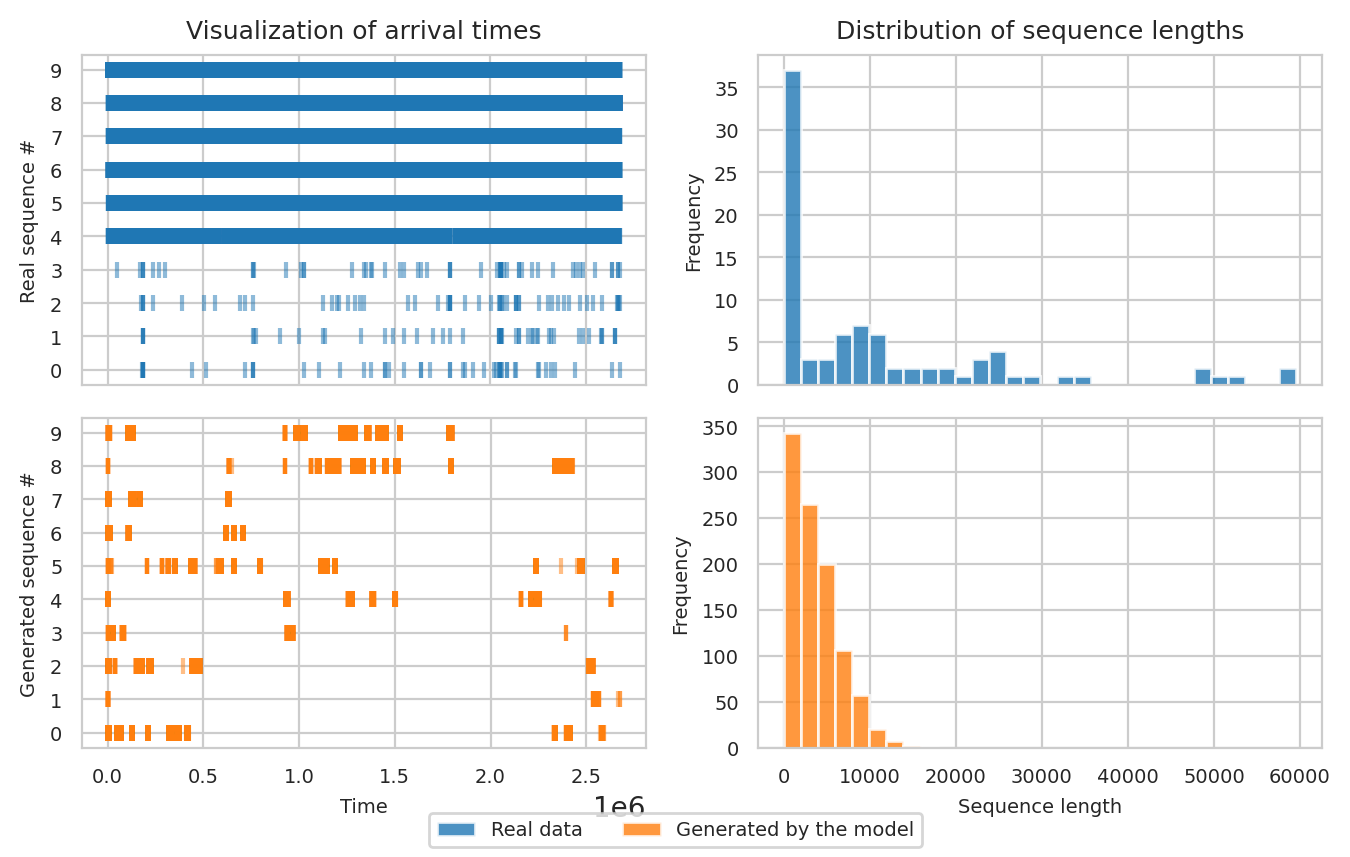

In [17]:
fig, axes = plt.subplots(figsize=[8, 4.5], dpi=200, nrows=2, ncols=2)
plt.subplots_adjust(hspace=0.1)
for idx, t in enumerate(arrival_times_list[:10]):
    axes[0, 0].scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C0', marker="|")
axes[0, 0].set_ylabel("Real sequence #", fontsize=7)
axes[0, 0].set_yticks(np.arange(10));
axes[0, 0].set_title("Visualization of arrival times", fontsize=9)


for idx, t in enumerate(generated_sequences[:10]):
    axes[1, 0].scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C1', marker="|")
axes[1, 0].set_xlabel("Time", fontsize=7)
axes[1, 0].set_ylabel("Generated sequence #", fontsize=7)
axes[1, 0].set_yticks(np.arange(10))
axes[0, 0].set_xticklabels([])

for ax in np.ravel(axes):
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

axes[0, 1].set_title("Distribution of sequence lengths", fontsize=9)
q_min = min(seq_lengths.min(), gen_seq_lengths.min())
q_max = max(seq_lengths.max(), gen_seq_lengths.max())
axes[0, 1].hist(seq_lengths, 30, alpha=0.8, color="C0", range=(q_min, q_max), label="Real data");
axes[0, 1].set_ylabel("Frequency", fontsize=7)
axes[0, 1].set_xticklabels([])

axes[1, 1].hist(gen_seq_lengths, 30, alpha=0.8, color="C1", range=(q_min, q_max), label="Generated by the model");
axes[1, 1].set_xlabel(r"Sequence length", fontsize=7)
axes[1, 1].set_ylabel("Frequency", fontsize=7)

fig.legend(loc="lower center", ncol=2, fontsize=7)